# Cutting stock problem with column generation

Source: https://github.com/bruscalia/optimization-demo-files/tree/c711c97e7bea736c23d0fa39500000fd52366117/mip/cutting_stock

Article: https://towardsdatascience.com/column-generation-in-linear-programming-and-the-cutting-stock-problem-3c697caf4e2b

## Restricted master problem

$$
\begin{align}
    \text{min} \quad & \sum_{p \in P} c_{p} x_{p} \\
    \text{s.t} \quad & d_{i} \leq \sum_{p \in P} a_{i, p} x_{p} & \forall \; i \in I \\
    & x_{p} \geq 0 & \forall \; p \in P \\
    & x_{p} \in \mathbb{Z} & \forall \; p \in P
\end{align}
$$

## Pricing problem

$$
\begin{align}
    \text{max} \quad & \sum_{i \in I} \pi_{i} y_{i} \\
    \text{s.t} \quad & \sum_{i \in I} w_{i} y_{i} \leq W\\
    & y_{i} \geq 0 & \forall \; i \in I \\
    & y_{i} \in \mathbb{Z} & \forall \; i \in I
\end{align}
$$

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("data.txt", sep=" ")
print(dataset.head())

      w   d
0  75.0  38
1  71.3  44
2  67.0  30
3  61.4  41
4  58.0  36


In [3]:
def solve_knapsack(W, w, duals):
    return linprog(-duals, A_ub=np.atleast_2d(w), b_ub=np.atleast_1d(W), bounds=(0, np.inf), integrality=1)

In [4]:
# Total width
W = 100.0

# Width and amount associated with each demand
w = dataset.w.values
d = dataset.d.values

# LP parameters
A = np.eye(dataset.shape[0]) * (W // w)
c = np.ones_like(w)

# Initial solution
sol = linprog(c, A_ub=-A, b_ub=-d, bounds=(0, None))
sol_dual = linprog(-d, A_ub=A.T, b_ub=c, bounds=(0, None))
print(sol)
print(sol.x)
diff = np.abs(sol_dual.x + sol.ineqlin.marginals).sum()
print(f"Compare duality difference: {diff}")

# Iterate
for _ in range(1000):
    duals = -sol.ineqlin.marginals
    price_sol = solve_knapsack(W, w, duals)
    y = price_sol.x
    if 1 + price_sol.fun < -1e-4:
        print(f"Iteration: {_}; Objective: {sol.x.sum()}; Reduced cost: {(1 + price_sol.fun):.3f}")
        A = np.hstack((A, y.reshape((-1, 1))))
        c = np.append(c, 1)
        sol = linprog(c, A_ub=-A, b_ub=-d, bounds=(0, None))
    else:
        break

sol_round = linprog(c, A_ub=-A, b_ub=-d, bounds=(0, np.inf), integrality=0)
print(f"Rounding solution {np.ceil(sol_round.x).sum()}")
sol = linprog(c, A_ub=-A, b_ub=-d, bounds=(0, np.inf), integrality=1)
print(f"Integer solution: {sol.x.sum()}")

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 413.7060606060606
              x: [ 3.800e+01  4.400e+01 ...  2.917e+00  3.267e+00]
            nit: 0
          lower:  residual: [ 3.800e+01  4.400e+01 ...  2.917e+00
                              3.267e+00]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
                 marginals: [-1.000e+00 -1.000e+00 ... -8.333e-02
                             -6.667e-02]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_g

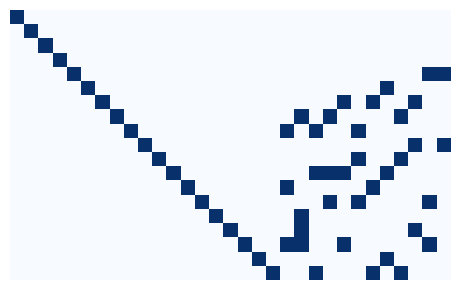

In [5]:
fig, ax = plt.subplots(figsize=[7, 3], dpi=100)
hmap = ax.imshow(A > 1e-6, cmap="Blues")
plt.axis('off')
fig.tight_layout()
plt.show()

In [6]:
print(sol)
print(sol.x)

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 334.0
              x: [ 3.800e+01  4.400e+01 ...  1.000e+00  3.500e+01]
            nit: -1
          lower:  residual: [ 3.800e+01  4.400e+01 ...  1.000e+00
                              3.500e+01]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 0.000e+00  0.000e+00 ...  3.100e+01
                              3.000e+00]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
 mip_node_count: 1
 mip_dual_bound: 334.0
        mip_gap: 0.0
[

In [7]:
print(c)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]


In [8]:
print(*[str(row)[1:-1] for row in A], sep='\n')

1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.
0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.
0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.
0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.
0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1.
0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0.
0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0.
0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0.
0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0.
0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1.
0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 